<a href="https://colab.research.google.com/github/budhiacharya/AI-Lesson/blob/main/Final_Project_AI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project: Loan Prediction
Predict whether a loan application will be approved (Loan_Status) based on applicant and loan characteristics.

In [2]:
# Import necessary libraries
import kagglehub
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path

from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    classification_report,
    RocCurveDisplay
)

1. Problem Definition and Dataset Selection
- Predict whether a loan application will be approved (Loan_Status) based on applicant and loan characteristics.
- For this problem, I am taking loan prediction data from Kaggle

In [3]:
# Download the Loan Prediction dataset using kagglehub
path = kagglehub.dataset_download("ninzaami/loan-predication")
print("Path to dataset files:", path)

data_dir = Path(path)
# Auto-detect the first CSV file in the folder
csv_files = list(data_dir.glob("*.csv"))

df = pd.read_csv(csv_files[0])
print("Loaded file:", csv_files[0].name)

# Quick check
df.head()

100%|██████████| 7.83k/7.83k [00:00<00:00, 9.98MB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/ninzaami/loan-predication/versions/1
Loaded file: train_u6lujuX_CVtuZ9i (1).csv


,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


2. Data Preprocessing and Exploration

In [4]:
# Basic exploration
# Shape and basic info
print("Shape:", df.shape)
print("\nInfo:")
print(df.info())

print("\nSummary statistics (numeric):")
display(df.describe())

print("\nUnique values per column:")
for col in df.columns:
    print(f"{col}: {df[col].nunique()} unique values")

Shape: (614, 13)

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             601 non-null    object 
 2   Married            611 non-null    object 
 3   Dependents         599 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      582 non-null    object 
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         592 non-null    float64
 9   Loan_Amount_Term   600 non-null    float64
 10  Credit_History     564 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 62.5+ KB
None

Summary statistics (numeric):


,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
count,614.000000,614.000000,592.000000,600.00000,564.000000
mean,5403.459283,1621.245798,146.412162,342.00000,0.842199
std,6109.041673,2926.248369,85.587325,65.12041,0.364878
min,150.000000,0.000000,9.000000,12.00000,0.000000
25%,2877.500000,0.000000,100.000000,360.00000,1.000000
50%,3812.500000,1188.500000,128.000000,360.00000,1.000000
75%,5795.000000,2297.250000,168.000000,360.00000,1.000000
max,81000.000000,41667.000000,700.000000,480.00000,1.000000



Unique values per column:
Loan_ID: 614 unique values
Gender: 2 unique values
Married: 2 unique values
Dependents: 4 unique values
Education: 2 unique values
Self_Employed: 2 unique values
ApplicantIncome: 505 unique values
CoapplicantIncome: 287 unique values
LoanAmount: 203 unique values
Loan_Amount_Term: 10 unique values
Credit_History: 2 unique values
Property_Area: 3 unique values
Loan_Status: 2 unique values


In [5]:
# Set target and basic cleaning
# Choose target column
TARGET_COL = "Loan_Status"  # 'Y' / 'N'

# Drop Loan_ID columns (not useful as features)
df_model = df.drop(columns='Loan_ID')

# Separate features and target
X = df_model.drop(columns=[TARGET_COL])
y = df_model[TARGET_COL]

# Convert binary categorical target to numeric (0/1)
if y.dtype == 'O' or y.dtype.name == 'category':

    unique_vals = y.dropna().unique()

    if len(unique_vals) == 2:
        print("Mapping target to 0/1:", unique_vals)

        # Sort to ensure consistent mapping (e.g., N=0, Y=1)
        unique_vals = sorted(unique_vals)

        mapping = {unique_vals[0]: 0, unique_vals[1]: 1}

        y = y.map(mapping)

    else:
        raise ValueError(f"Target has {len(unique_vals)} categories. Expected exactly 2 for binary classification.")

else:
    print("Target already numeric.")



Mapping target to 0/1: ['Y' 'N']


In [6]:
# Train–test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("Train shape:", X_train.shape, "Test shape:", X_test.shape)

Train shape: (491, 11) Test shape: (123, 11)


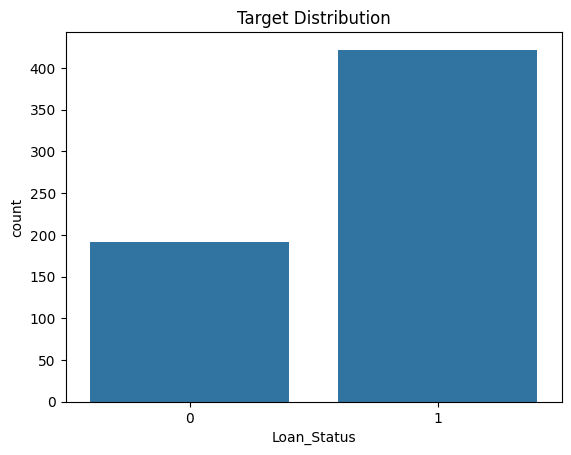

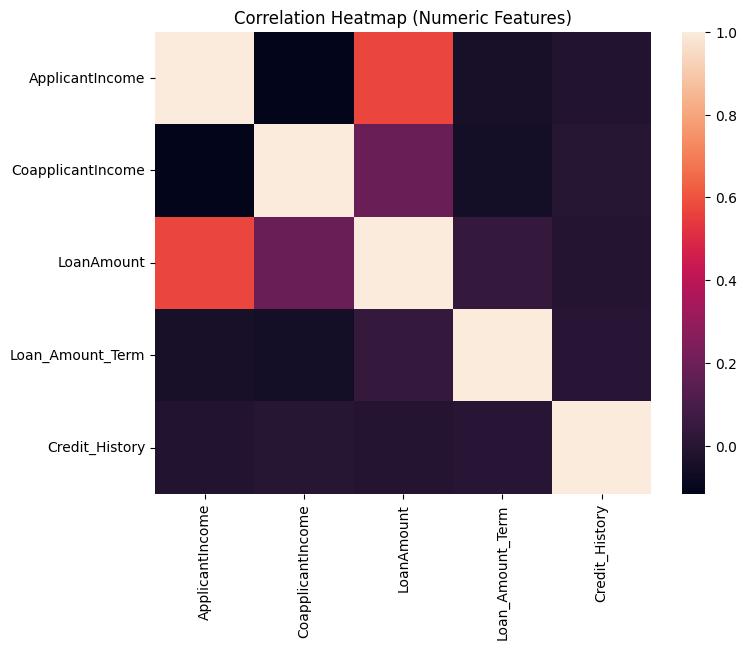

In [7]:
# simple visualizations
# Target distribution
plt.figure()
sns.countplot(x=y)
plt.title("Target Distribution")
plt.show()

# Correlation heatmap (numeric only)
numeric_cols = X.select_dtypes(include=['int64', 'float64']).columns
plt.figure(figsize=(8, 6))
sns.heatmap(df_model[numeric_cols].corr(), annot=False)
plt.title("Correlation Heatmap (Numeric Features)")
plt.show()


Preprocessing Pipelines (Imputation, Encoding, Scaling), i.e. handling missing values, and doing normalization and encoding.

In [8]:
# Identify numeric and categorical columns automatically
numeric_features = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X_train.select_dtypes(include=['object', 'category', 'bool']).columns.tolist()

print("Numeric features:", numeric_features)
print("Categorical features:", categorical_features)

# Numeric pipeline: median imputation and scaling
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

# Categorical pipeline: most frequent imputation and one-hot encoding
categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

# Combine into a ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ]
)

Numeric features: ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term', 'Credit_History']
Categorical features: ['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Property_Area']


 3. Model Selection and Development
- Logistic Regression (baseline)
- Random Forest (stronger)

In [9]:
# Baseline: Logistic Regression
log_reg_clf = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", LogisticRegression(
        max_iter=1000,
        class_weight="balanced",
        random_state=42
    ))
])

# Train baseline
log_reg_clf.fit(X_train, y_train)

# Cross-validation accuracy
cv_scores = cross_val_score(log_reg_clf, X_train, y_train, cv=5, scoring="accuracy", n_jobs=-1)
print("Logistic Regression CV Accuracy: {:.4f} ± {:.4f}".format(cv_scores.mean(), cv_scores.std()))

Logistic Regression CV Accuracy: 0.7332 ± 0.0206


In [10]:
# Random Forest, Hyperparameter Tuning, Cross-validation
rf_clf = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", RandomForestClassifier(random_state=42))
])

# Hyperparameter search space
param_distributions = {
    "model__n_estimators": [100, 200, 300, 400, 500],
    "model__max_depth": [None, 3, 5, 7, 10],
    "model__min_samples_split": [2, 5, 10],
    "model__min_samples_leaf": [1, 2, 4],
    "model__max_features": ["sqrt", "log2", 0.5]
}

random_search = RandomizedSearchCV(
    rf_clf,
    param_distributions=param_distributions,
    n_iter=30,
    scoring="accuracy",
    cv=5,
    random_state=42,
    n_jobs=-1,
    verbose=1
)

random_search.fit(X_train, y_train)

print("Best parameters:", random_search.best_params_)
print("Best CV score:", random_search.best_score_)
best_model = random_search.best_estimator_

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best parameters: {'model__n_estimators': 200, 'model__min_samples_split': 5, 'model__min_samples_leaf': 4, 'model__max_features': 0.5, 'model__max_depth': 5}
Best CV score: 0.8004122861265719


5. Model Evaluation and Optimization
- Evaluate on test set
- Use multiple metrics
- Compare baseline vs tuned model
- ROC curve and confusion matrix

In [11]:
# Helper function for evaluation
def evaluate_classifier(model, X_train, y_train, X_test, y_test, model_name="Model"):
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Probabilities for ROC AUC (if available)
    if hasattr(model, "predict_proba"):
        y_test_proba = model.predict_proba(X_test)[:, 1]
        auc = roc_auc_score(y_test, y_test_proba)
    else:
        y_test_proba = None
        auc = None

    print(f"\n=== {model_name} Evaluation ===")
    print("Train Accuracy: {:.4f}".format(accuracy_score(y_train, y_train_pred)))
    print("Test Accuracy:  {:.4f}".format(accuracy_score(y_test, y_test_pred)))
    print("Precision:      {:.4f}".format(precision_score(y_test, y_test_pred, zero_division=0)))
    print("Recall:         {:.4f}".format(recall_score(y_test, y_test_pred, zero_division=0)))
    print("F1-score:       {:.4f}".format(f1_score(y_test, y_test_pred, zero_division=0)))
    if auc is not None:
        print("ROC AUC:        {:.4f}".format(auc))

    print("\nClassification Report:")
    print(classification_report(y_test, y_test_pred, zero_division=0))

    # Confusion matrix
    cm = confusion_matrix(y_test, y_test_pred)
    plt.figure(figsize=(4, 3))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"{model_name} - Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()

    # ROC curve if probabilities available
    if y_test_proba is not None:
        RocCurveDisplay.from_predictions(y_test, y_test_proba)
        plt.title(f"{model_name} - ROC Curve")
        plt.show()


=== Logistic Regression Evaluation ===
Train Accuracy: 0.7536
Test Accuracy:  0.8293
Precision:      0.8721
Recall:         0.8824
F1-score:       0.8772
ROC AUC:        0.8551

Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.71      0.72        38
           1       0.87      0.88      0.88        85

    accuracy                           0.83       123
   macro avg       0.80      0.80      0.80       123
weighted avg       0.83      0.83      0.83       123



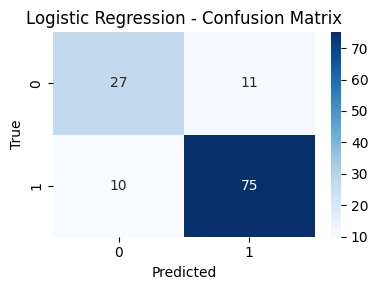

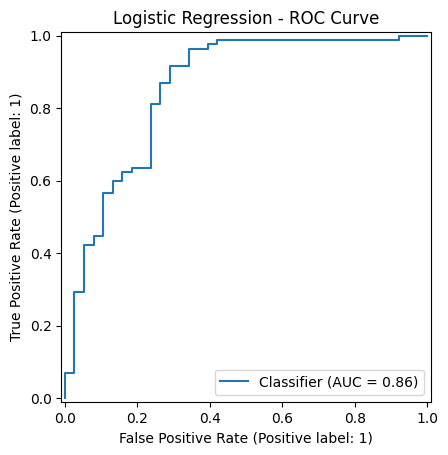


=== Random Forest (Tuned) Evaluation ===
Train Accuracy: 0.8004
Test Accuracy:  0.8537
Precision:      0.8317
Recall:         0.9882
F1-score:       0.9032
ROC AUC:        0.7960

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.55      0.70        38
           1       0.83      0.99      0.90        85

    accuracy                           0.85       123
   macro avg       0.89      0.77      0.80       123
weighted avg       0.87      0.85      0.84       123



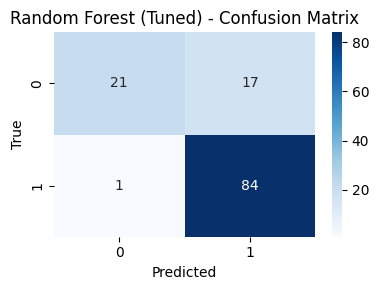

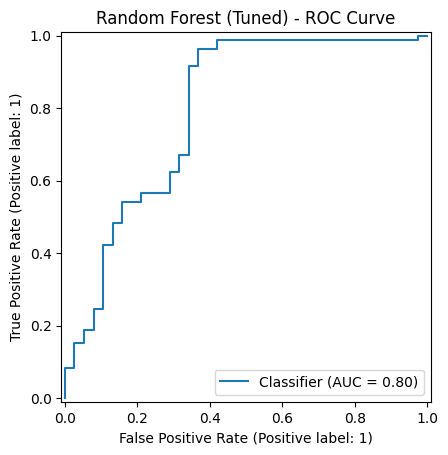

In [12]:
# Logistic Regression
evaluate_classifier(log_reg_clf, X_train, y_train, X_test, y_test, model_name="Logistic Regression")

# Tuned Random Forest
evaluate_classifier(best_model, X_train, y_train, X_test, y_test, model_name="Random Forest (Tuned)")


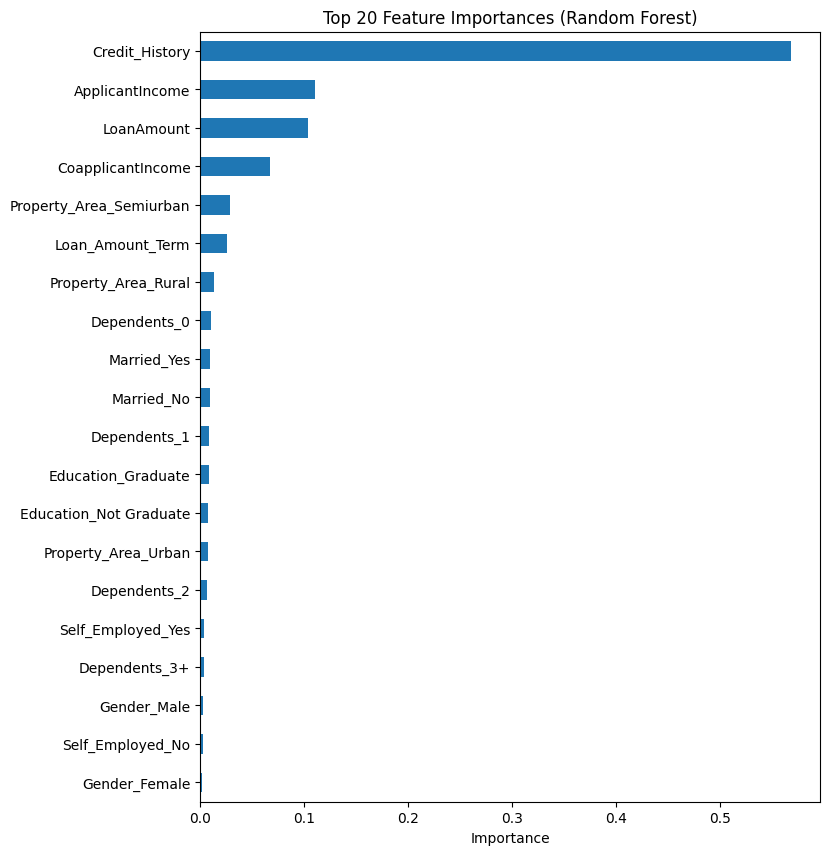

In [13]:
# Feature importance (for Random Forest)
# Get feature names after preprocessing
preproc = best_model.named_steps["preprocessor"]
rf = best_model.named_steps["model"]

# Column names after transformation
ohe = preproc.named_transformers_["cat"].named_steps["onehot"]
cat_feature_names = ohe.get_feature_names_out(categorical_features)
all_feature_names = np.concatenate([numeric_features, cat_feature_names])

importances = rf.feature_importances_
feat_imp = pd.Series(importances, index=all_feature_names).sort_values(ascending=False)

plt.figure(figsize=(8, 10))
feat_imp.head(20).plot(kind="barh")
plt.gca().invert_yaxis()
plt.title("Top 20 Feature Importances (Random Forest)")
plt.xlabel("Importance")
plt.show()

In [14]:
# Save best model for deployment
import joblib
joblib.dump(best_model, "loan_approval_rf_model.pkl")
print("Model saved as loan_approval_rf_model.pkl")

Model saved as loan_approval_rf_model.pkl


In [15]:
print("Number of features:", len(X_train.columns))
print("Feature names:", list(X_train.columns))

Number of features: 11
Feature names: ['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term', 'Credit_History', 'Property_Area']


User-friendly interactive interface (widgets inside Colab)

In [16]:
# User-friendly interactive interface
!pip install ipywidgets -q
from ipywidgets import widgets, VBox
from IPython.display import display, clear_output
import numpy as np

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 13.4 MB/s eta 0:00:00


In [17]:
# Create input widgets for each feature in X_train
input_widgets = {}

for col in X_train.columns:
    col_data = X_train[col]
    # Numeric columns
    if np.issubdtype(col_data.dtype, np.number):
        # Use median as a default value
        default_value = float(col_data.median())
        w = widgets.FloatText(
            value=default_value,
            description=col,
            layout=widgets.Layout(width="50%")
        )
    else:
        # Categorical column: use unique values as options
        options = sorted(col_data.dropna().unique().tolist())
        # Fallback if column is all NaN (rare)
        if len(options) == 0:
            options = ["Unknown"]
        w = widgets.Dropdown(
            options=options,
            description=col,
            layout=widgets.Layout(width="50%")
        )
    input_widgets[col] = w

In [18]:
# Prediction button and output area
predict_button = widgets.Button(
    description="Predict Loan Approval",
    button_style="success",
    layout=widgets.Layout(width="30%")
)

output = widgets.Output()

Define the prediction logic for the UI

In [19]:
def on_predict_clicked(b):
    # Build a single-row DataFrame from widget values
    data = {col: [w.value] for col, w in input_widgets.items()}
    example_df = pd.DataFrame(data)

    # Make prediction
    pred = loaded_model.predict(example_df)[0]

    # Try to get probability
    if hasattr(loaded_model, "predict_proba"):
        proba = loaded_model.predict_proba(example_df)[0][1]
    else:
        proba = None

    with output:
        clear_output()
        print("=== Loan Prediction Result ===")
        # Assuming 1 = Approved, 0 = Not Approved
        label = "Approved ✅" if pred == 1 else "Not Approved ❌"
        print("Prediction:", label)
        if proba is not None:
            print(f"Approval probability: {proba:.2%}")
        print("\nInput details:")
        display(example_df)

predict_button.on_click(on_predict_clicked)


Display the interface

In [20]:
form_items = [w for w in input_widgets.values()] + [predict_button, output]
ui = VBox(form_items)
display(ui)